### Image to Image Translation with conditional GAN. **(`cGAN`)**.

In this notebook we will implement a `cGAN` called pix2pix that learns mapping input images to output images described in [this](https://arxiv.org/abs/1611.07004) paper.


> pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.


In this notebook we will generate images of building facades using [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep it short, you will use a [preprocessed copy]((https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/)) of this dataset created by the pix2pix authors.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).



### Imports

In [1]:
import tensorflow as tf
import os, time, datetime
from matplotlib import pyplot as plt

### Loading the Dataset.

Let's load the CMP Facade Database data. (You can try other preprocessed pix2pix-related datasets [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets).)

In [2]:
url = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    'facades.tar.gz',
    origin = url,
    extract=True
)
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 7s 0us/step


#### Images.
Eeach image is of size `256 x 512` containing two images of size `256 x 256`.

### Visulizing one image.

In [3]:
sample_image = tf.io.read_file(os.path.join(PATH, 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
sample_image.shape

TensorShape([256, 512, 3])

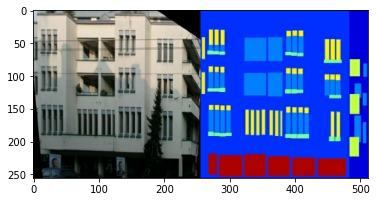

In [4]:
plt.imshow(sample_image)
plt.show()

### Next.
We need to separate real buildings facade images from the architecture label images so that each image will have a size of `256 x 266`.

Let's define a function that loads image files and output two image tensors.

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  """
  Splitting image tensors into two tensors. One with a real 
  building and the other with an architecture label image
  """
  w = tf.shape(image)[1]
  w = w // 2

  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  """
  Converting both images to float32 tensors
  """
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  return input_image, real_image


### Ploting Splited Images.

In [6]:
def plot_image_pairs(images, labels, cols=2, rows=1):
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title(label, color ='g', fontsize=16 )

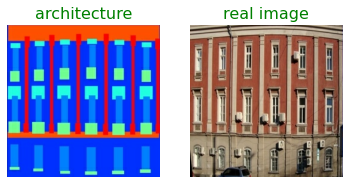

In [7]:
inp, re = load(os.path.join(PATH, 'train/10.jpg'))
plot_image_pairs([inp/255.0, re/255.0], labels=["architecture", "real image"])

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), we need to apply random jittering and mirroring to preprocess the training set.

We are going to define several functions that:

1. Resize each `256 x 256` image to a larger height and width —`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right **(random mirroring)**.
4. Normalize the images to the `[-1, 1]` range.

### Hyper params

In [8]:
IMG_HEIGHT = IMG_WIDTH = 256
"""
The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
"""
BATCH_SIZE = 1
BUFFER_SIZE = 400

### Image resize

In [9]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, (height, width),
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, (height, width),
                               method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

### Random image resize.

In [10]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis =0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
  )
  return cropped_image[0], cropped_image[1]

### Normalizing images.

Normalizing image means scaling image pixels to be in range `[-1, 1]`

In [11]:
def normalize(input_image, real_image):
  input_image = (input_image/127.5) -1
  real_image = (real_image/127.5) -1
  return input_image, real_image

### Random jittering.

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
  """
  resize the image to 286 x 286
  """
  input_image, real_image = resize(input_image, real_image, 286, 286)
  """
  Random croping back to 256 x 256
  """
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(())> .5:
    """
    Random mirroring
    """
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image

### Displaying processed image.

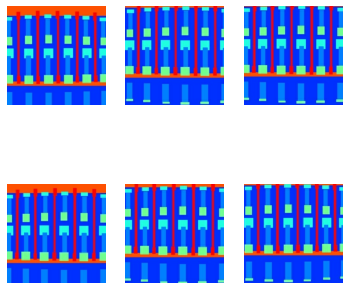

In [13]:
plt.figure(figsize=(6, 6))
for i in range(6):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 3, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

### Helper functions.

Let's define helper function that loads the train and test images and process them.

In [14]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

"""
DURING TRAINING LOADING WE only want to resize the image. No random jitter
is applied here. We will also normalize the images to have pixels in range
[-1, 1]
"""
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(
      input_image, real_image, IMG_HEIGHT, IMG_WIDTH
  )
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

### Building an input pipeline with `tf.data`.

In [15]:
train_ds = tf.data.Dataset.list_files(PATH +'train/*.jpg')
train_ds = train_ds.map(load_image_train,
                        num_parallel_calls = tf.data.AUTOTUNE
                        ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



In [16]:
test_ds = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_ds = test_ds.map(load_image_test).batch(BATCH_SIZE)

### Generator model.

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

### Encoder.

Each block is:
```
[ Convolution ] -> [Batch Normalization] -> [Leaky ReLU]
```

### Decoder.
Each block is:

```
[ Convolution ] -> [ Batch Normalization] -> [ Dropout] -> [ ReLU]
```

The `dropout` in the decoder is applied to the first three blocks. 

* There are skip connections between the encoder and decoder (as in U-Net).


### Downsampler (encoder)


In [17]:
OUTPUT_CHANNELS = 3

In [18]:
from tensorflow import keras

In [19]:
def downsample(filters, kernel_size, apply_batchnom=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = keras.Sequential()
  result.add(
      keras.layers.Conv2D(
          filters, kernel_size = kernel_size, strides=2,
          padding="same",
          kernel_initializer=initializer, use_bias=False
      )
  )

  if apply_batchnom:
    result.add(keras.layers.BatchNormalization())
  
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [20]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


### Define the upsampler (decoder).

In [21]:
def upsample(filters, kernel_size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., .02)
  result = keras.Sequential()

  result.add(keras.layers.Conv2DTranspose(
      filters, kernel_size=kernel_size, strides=2,
      padding="same",
      kernel_initializer= initializer,
      use_bias = False
  ))

  result.add(keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(keras.layers.Dropout(.5))

  result.add(tf.keras.layers.ReLU())
  return result

In [22]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
up_result.shape

TensorShape([1, 256, 256, 3])

### The Generator.
The generator will first downsample the image and then upsample using the downsampler and upsampler.

```
|                        |
|   |               |    |
|   |   |      |    |    |
|   |   |   |  |    |    |

(downsampling) (upsampling)
  (encoder)      (decoder)
```


In [23]:
def generator():
  inputs = keras.layers.Input(shape=[256, 256, 3])

  """
  Down sampling
  """

  down_stack = [
    downsample(64, 4, apply_batchnom=False),# (batch_size, 128, 128, 64)
    downsample(128, 4), # (batch_size, 64, 64, 128)
    downsample(256, 4), # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  """
  Up sampling
  """
  up_stack = [
    upsample(512, 4, apply_dropout=True), # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = keras.layers.Conv2DTranspose(
      OUTPUT_CHANNELS,
      4, strides=2,
      padding= 'same',
      kernel_initializer = initializer,
      activation = 'tanh'
  ) # (batch_size, 256, 256, 3)
  x = inputs

  """
  DOWNSAMPLING THROUG THE MODEL
  """
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  """
  UPSAMPLING AND ESTABILISHING SKIP CONNECTIONS.
  """
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = keras.layers.Concatenate()([x, skip])

  x = last(x)
  return keras.Model(inputs=inputs, outputs=x, name="generator_model")

generator().summary() 

Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
____________________________________________________________________________________

### Visualizing the generator model.

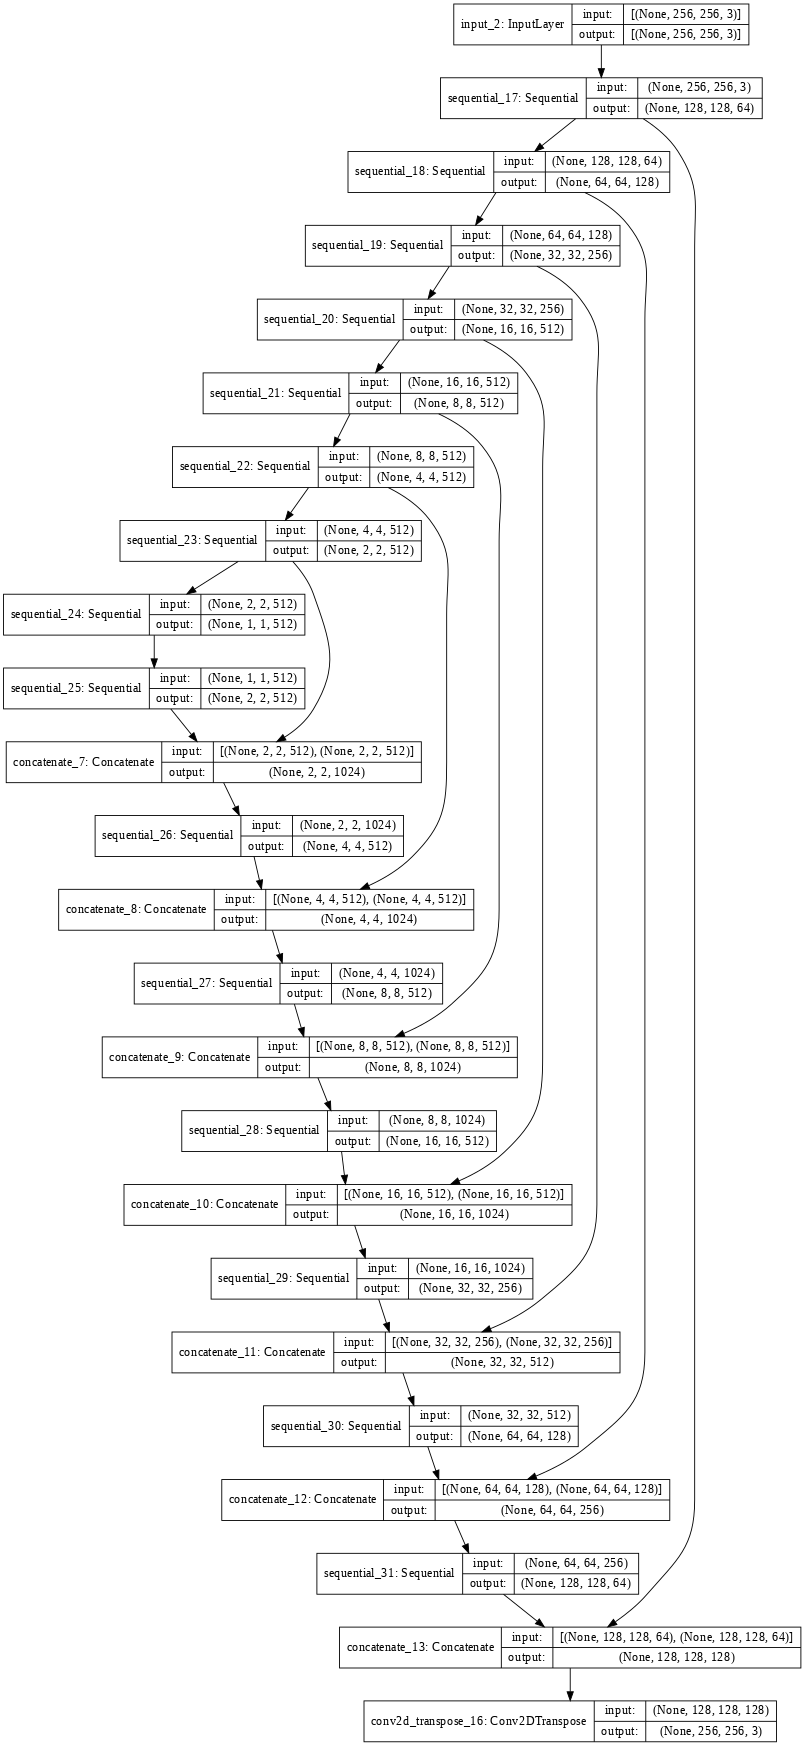

In [24]:
generator_model = generator()
keras.utils.plot_model(generator_model, show_shapes=True, dpi=64)

#### Testing the generator.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)


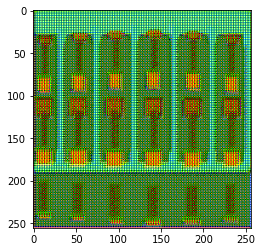

In [25]:
gen_output = generator_model(inp[tf.newaxis, ...], training=False)
print(gen_output.shape)
plt.imshow(gen_output[0, :, :, :])
plt.show()

### Generator loss.

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.


In [26]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

In [27]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), 
                         disc_generated_output)
  ## MAE
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

<p align="center"><img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1"/></p>

### Build the discriminator.

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

Each block of the descriminator looks as follows:

```
[ Convolution ] -> [Batch normalization] -> [ Leaky ReLU ]
```

- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

In [28]:
def discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = keras.layers.Input(shape=[256, 256, 3], name="input_image")
  tar = keras.layers.Input(shape=(256, 256, 3), name="target_image")

  x = keras.layers.concatenate([inp, tar], name="concatenated_inputs") # (batch_size, 256, 256, channels*2)
  down_1 = downsample(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down_2 = downsample(128, 4)(down_1)  # (batch_size, 64, 64, 128)
  down_3 = downsample(256, 4)(down_2) # (batch_size, 32, 32, 256)

  zero_pad1 = keras.layers.ZeroPadding2D(name="zero_padding_layer_1")(down_3) # (batch_size, 34, 34, 256)
  
  conv = keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                             use_bias=False,
                             name="conv_layer")(zero_pad1)
  bn_1 =  keras.layers.BatchNormalization(name="bn_1")(conv)
  leaky_relu = keras.layers.LeakyReLU(name="leaky_relu")(bn_1)
  zero_pad2 = keras.layers.ZeroPadding2D(name="zero_padding_layer_2")(leaky_relu) # (batch_size, 33, 33, 512)
  last = keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer,
                             name="output_layer"
                             )(zero_pad2)  # (batch_size, 30, 30, 1)

  return keras.Model(inputs=[inp, tar], outputs=last, name="discriminator_model")
discriminator().summary()

Model: "discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenated_inputs (Concatenat (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_32 (Sequential)      (None, 128, 128, 64) 6144        concatenated_in

### Visualizing the `Discriminator` model achitecture.

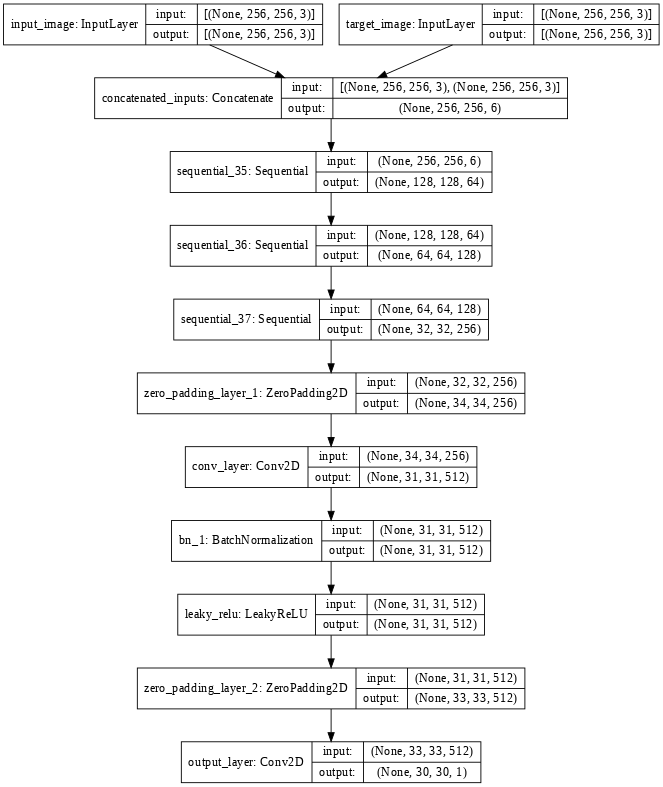

In [29]:
discriminator_model = discriminator()
keras.utils.plot_model(discriminator_model, show_shapes=True, dpi=64)

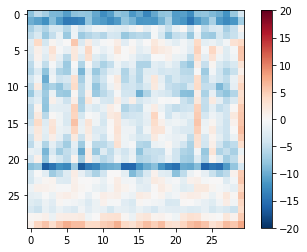

In [30]:
disc_out = discriminator_model([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

### Discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(
      tf.ones_like(disc_real_output), disc_real_output
  )
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  return real_loss + generated_loss

### Training the Discriminator

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

<p>
<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1"/></p>

### Optimizers.
We are going to train these model with the same optimizer.

In [32]:
generator_optimizer = discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoint-saver.

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

### Generate images

We will create a function that will plot images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions

Note: The `training=True` is intentional here since
we want the batch statistics, while running the model on the test dataset. If we use `training=False`, we get the accumulated statistics learned from the training dataset **(which we don't want)**.

In [34]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  images = [test_input[0], tar[0], prediction[0]]
  titles = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i, (title, image) in enumerate(zip(titles, images)):
    plt.subplot(1, 3, i+1)
    plt.title(title)
    """
    Getting the pixel values in the [0, 1] range to plot.
    """
    plt.imshow(image * .5 + .5)
    plt.axis('off')
  plt.show()

### Let's test our function.

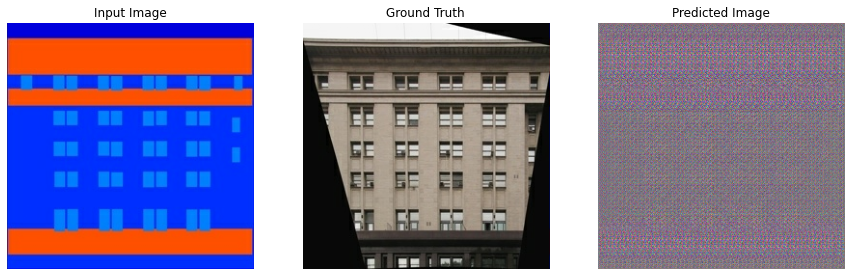

In [35]:
for example_input, example_target in test_ds.take(1):
  generate_images(generator_model, example_input, example_target)

### Now, Training.

* For each example input generates an output.
* The discriminator receives the `input_image` and the `generated image` as the first input. The second input is the `input_image` and the `target_image`.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator `variables(inputs)` and apply those to the optimizer.
* I'm not going to log the loses on tensorboard as they did in [this](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb?authuser=2#scrollTo=NLKOG55MErD0) tutorial.

In [36]:
EPOCHS = 150

In [37]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator_model(input_image, training=True)
    disc_real_output = discriminator_model([input_image, target], training=True)
    disc_generated_output = discriminator_model([input_image, gen_output], training=True)
    
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
        disc_generated_output, 
        gen_output, target
        )
    disc_loss = discriminator_loss(disc_real_output, 
                                   disc_generated_output
                                   )
  gradients_of_generator = gen_tape.gradient(
    gen_total_loss, generator_model.trainable_variables 
  )

  gradients_of_discriminator = disc_tape.gradient(
      disc_loss, discriminator_model.trainable_variables
  )
  
  generator_optimizer.apply_gradients(
      zip(
          gradients_of_generator,  generator_model.trainable_variables 
      )
  )
  discriminator_optimizer.apply_gradients(
      zip(
       gradients_of_discriminator,  discriminator_model.trainable_variables    
      )
  )


### Trainning loop.
- Iterates over the number of epochs.
- At each epoch: clears the display and runs `generate_images` to show the progress.
- At each epoch: iterates over the training dataset, printing a dot (`.`) to indicate progress for each example.
- Every 20 epochs: saves a checkpoint.

In [38]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [39]:
from prettytable import PrettyTable

In [40]:

def tabulate_training_epochs(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [41]:
def fit(train_ds, epochs, test_ds):
  columns_data =["EPOCH", "ETA"]
  for epoch in range(epochs):
    start = time.time()
    """TRAIN STEP"""
    for n, (input_image, target) in train_ds.enumerate():
      train_step(input_image, target, epoch)
    """Saving (checkpointing) the model every 20 epochs"""
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    end = time.time()

    rows_data = [
       [epoch+1, hms_string(end - start)]          
    ]
    title = f'EPOCH {epoch+1:02}/{epochs} {"display" if epoch == 0 or (epoch+1)%20 == 0 else "no display"}'
    tabulate_training_epochs(columns_data, rows_data, title)
    """Display images after every 20 epoch"""
    if epoch == 0 or (epoch+1)%20 == 0:
      for example_input, example_target in test_ds.take(1):
        generate_images(generator_model, example_input, example_target)

### Running the training loop.

+-----------------------+
| EPOCH :01/150 display |
+--------+--------------+
| EPOCH  |          ETA |
+--------+--------------+
| 1      |   0:00:40.77 |
+--------+--------------+


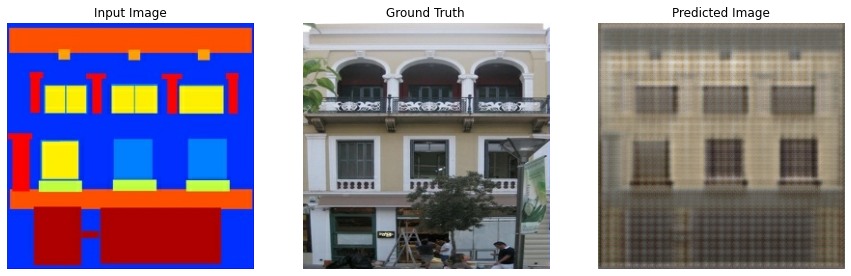

+--------------------------+
| EPOCH :02/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 2       |     0:00:38.79 |
+---------+----------------+
+--------------------------+
| EPOCH :03/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 3       |     0:00:38.40 |
+---------+----------------+
+--------------------------+
| EPOCH :04/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 4       |     0:00:38.61 |
+---------+----------------+
+--------------------------+
| EPOCH :05/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 5       |     0:00:38.28 |
+---------+----------------+
+--------------------------+
| EPOCH :06/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 6       |     0:00:38.43 |
+---------+---

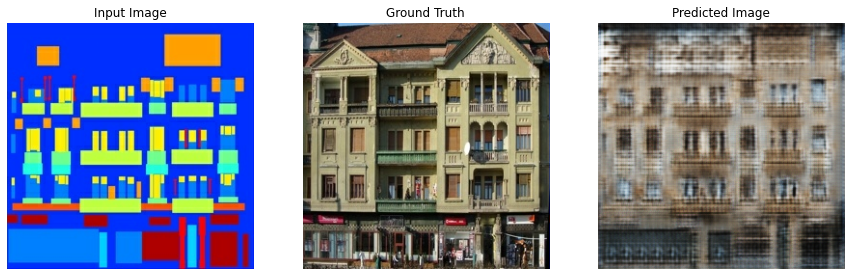

+--------------------------+
| EPOCH :21/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 21      |     0:00:38.73 |
+---------+----------------+
+--------------------------+
| EPOCH :22/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 22      |     0:00:38.33 |
+---------+----------------+
+--------------------------+
| EPOCH :23/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 23      |     0:00:38.39 |
+---------+----------------+
+--------------------------+
| EPOCH :24/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 24      |     0:00:38.37 |
+---------+----------------+
+--------------------------+
| EPOCH :25/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 25      |     0:00:38.36 |
+---------+---

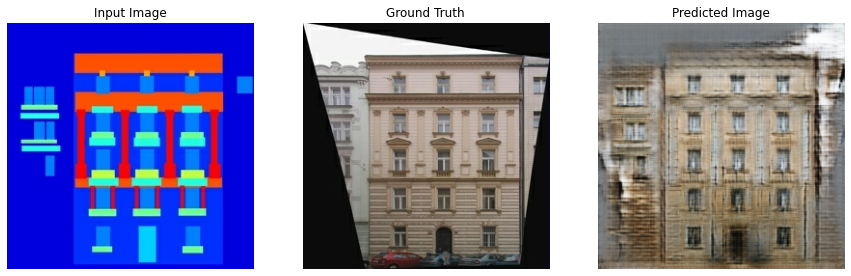

+--------------------------+
| EPOCH :41/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 41      |     0:00:38.44 |
+---------+----------------+
+--------------------------+
| EPOCH :42/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 42      |     0:00:38.74 |
+---------+----------------+
+--------------------------+
| EPOCH :43/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 43      |     0:00:38.33 |
+---------+----------------+
+--------------------------+
| EPOCH :44/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 44      |     0:00:38.36 |
+---------+----------------+
+--------------------------+
| EPOCH :45/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 45      |     0:00:38.27 |
+---------+---

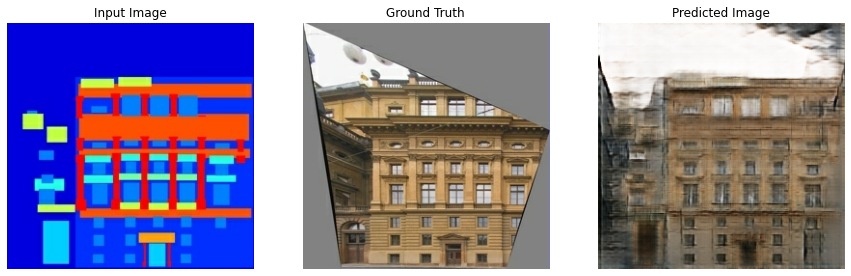

+--------------------------+
| EPOCH :61/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 61      |     0:00:39.50 |
+---------+----------------+
+--------------------------+
| EPOCH :62/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 62      |     0:00:38.42 |
+---------+----------------+
+--------------------------+
| EPOCH :63/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 63      |     0:00:38.40 |
+---------+----------------+
+--------------------------+
| EPOCH :64/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 64      |     0:00:38.47 |
+---------+----------------+
+--------------------------+
| EPOCH :65/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 65      |     0:00:38.52 |
+---------+---

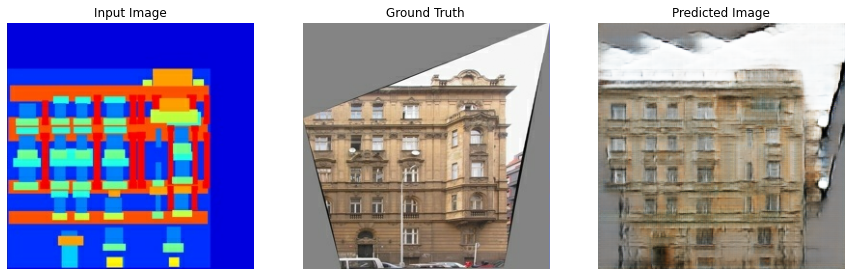

+--------------------------+
| EPOCH :81/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 81      |     0:00:38.54 |
+---------+----------------+
+--------------------------+
| EPOCH :82/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 82      |     0:00:38.37 |
+---------+----------------+
+--------------------------+
| EPOCH :83/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 83      |     0:00:38.34 |
+---------+----------------+
+--------------------------+
| EPOCH :84/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 84      |     0:00:38.25 |
+---------+----------------+
+--------------------------+
| EPOCH :85/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 85      |     0:00:38.31 |
+---------+---

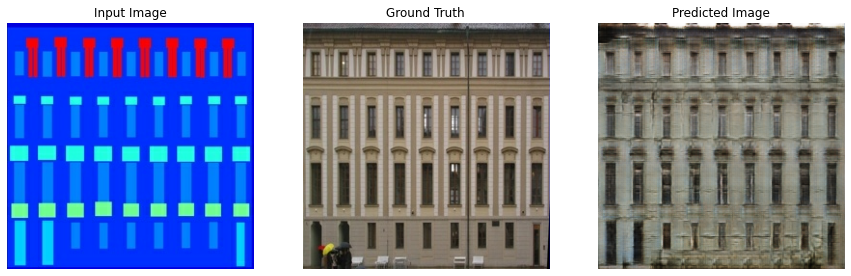

+--------------------------+
| EPOCH :101/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 101     |     0:00:38.40 |
+---------+----------------+
+--------------------------+
| EPOCH :102/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 102     |     0:00:38.26 |
+---------+----------------+
+--------------------------+
| EPOCH :103/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 103     |     0:00:38.38 |
+---------+----------------+
+--------------------------+
| EPOCH :104/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 104     |     0:00:38.40 |
+---------+----------------+
+--------------------------+
| EPOCH :105/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 105     |     0:00:38.25 |
+--------

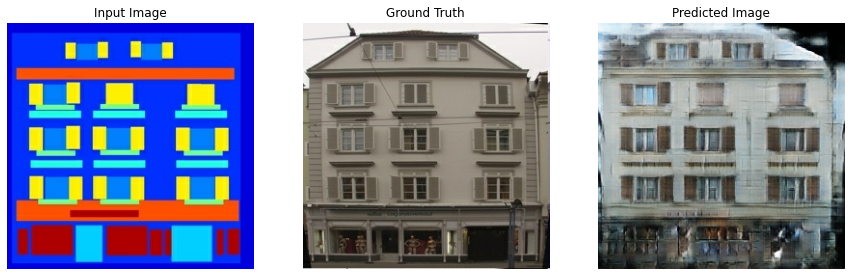

+--------------------------+
| EPOCH :121/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 121     |     0:00:39.18 |
+---------+----------------+
+--------------------------+
| EPOCH :122/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 122     |     0:00:38.46 |
+---------+----------------+
+--------------------------+
| EPOCH :123/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 123     |     0:00:38.34 |
+---------+----------------+
+--------------------------+
| EPOCH :124/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 124     |     0:00:38.26 |
+---------+----------------+
+--------------------------+
| EPOCH :125/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 125     |     0:00:38.32 |
+--------

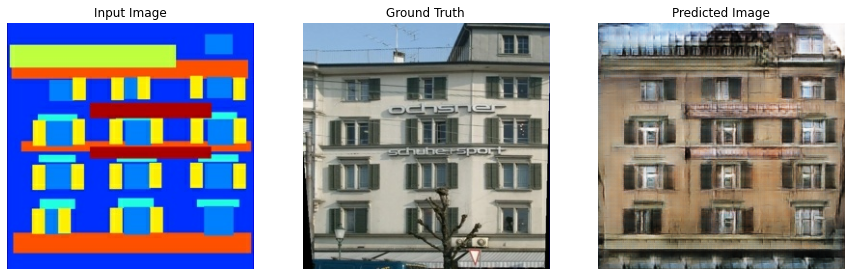

+--------------------------+
| EPOCH :141/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 141     |     0:00:38.49 |
+---------+----------------+
+--------------------------+
| EPOCH :142/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 142     |     0:00:38.30 |
+---------+----------------+
+--------------------------+
| EPOCH :143/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 143     |     0:00:38.28 |
+---------+----------------+
+--------------------------+
| EPOCH :144/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 144     |     0:00:38.22 |
+---------+----------------+
+--------------------------+
| EPOCH :145/150 no display |
+---------+----------------+
| EPOCH   |            ETA |
+---------+----------------+
| 145     |     0:00:38.34 |
+--------

In [42]:
fit(train_ds, EPOCHS, test_ds)

### Restore the latest checkpoint and test the network.


In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Generating images using the `test_set`.

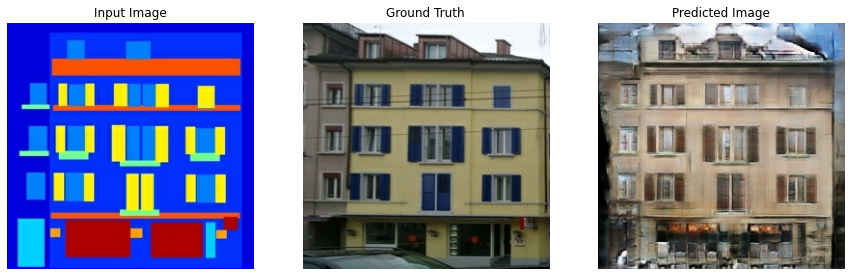

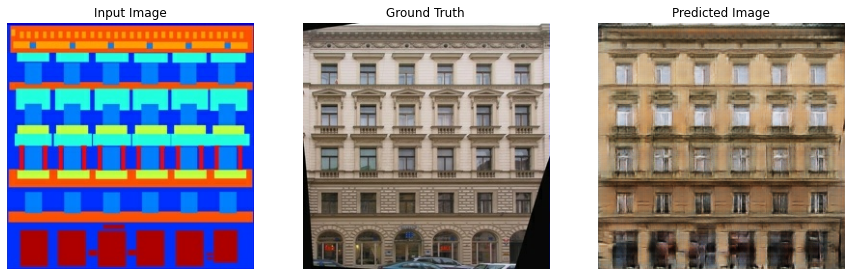

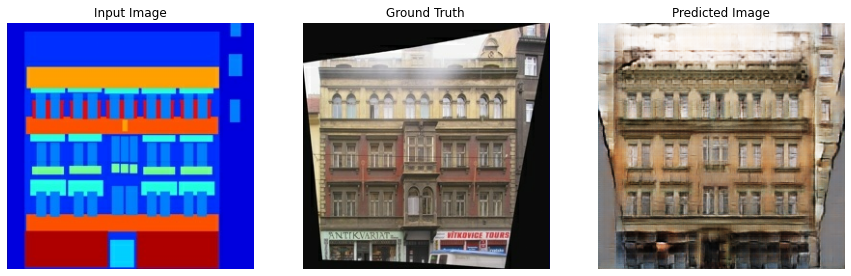

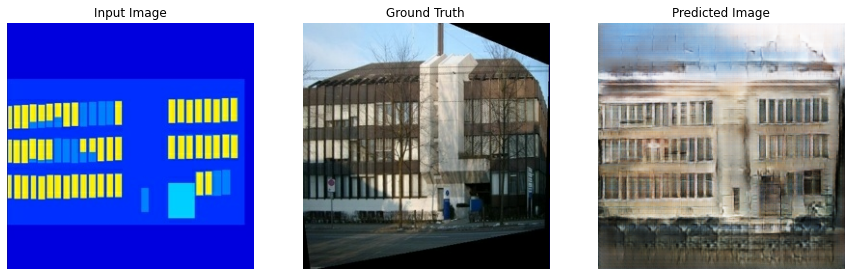

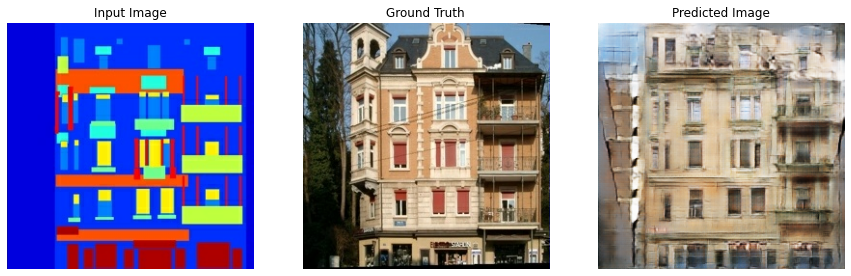

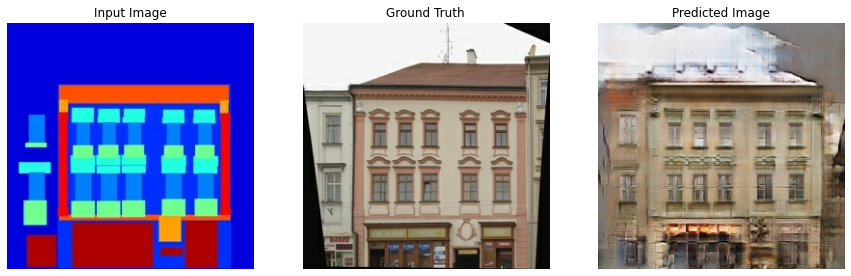

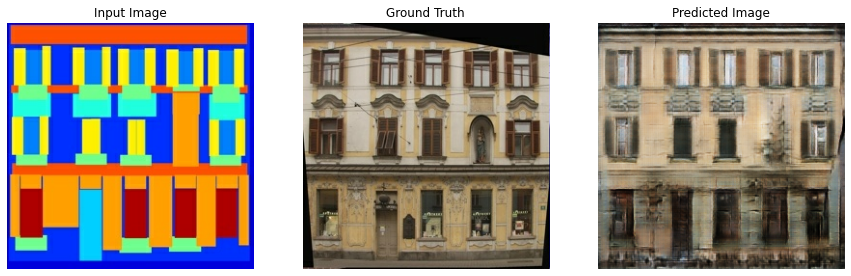

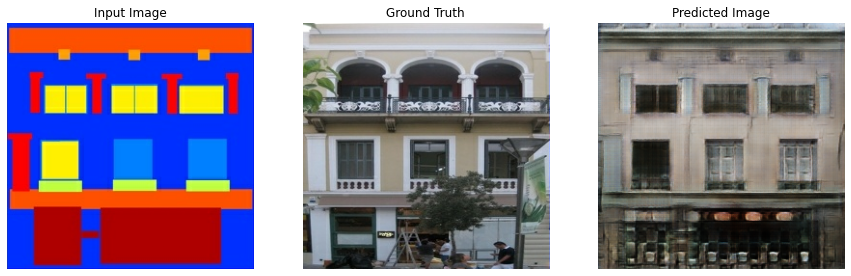

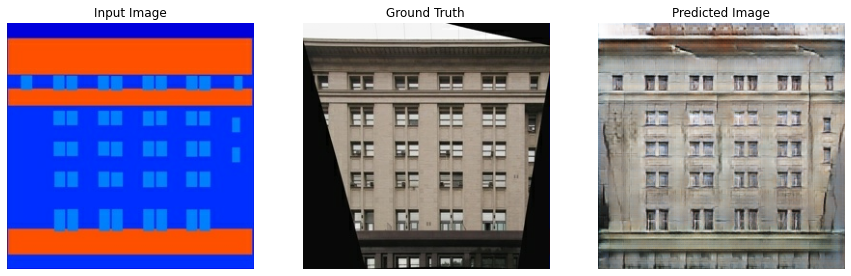

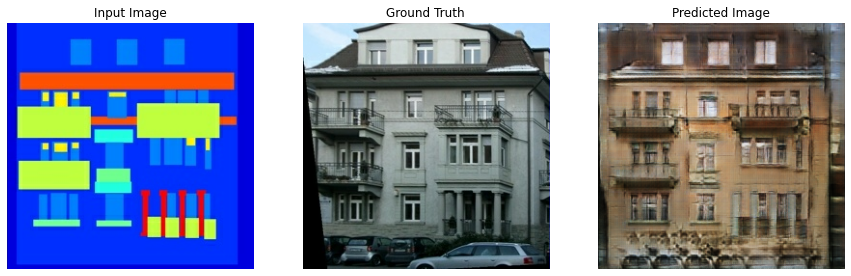

In [44]:
for inp, tar in test_ds.take(10):
  generate_images(generator_model, inp, tar)

### Ref.

* This notebook was extracted from the [this tensorflow tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb?authuser=2#scrollTo=4t4x69adQ5xb)
* In this notebook i didn't cover the part of tensorflow board.